In [1]:
# Core scverse libraries
import scanpy as sc
import anndata as ad
import scvelo as scv
import os
import glob
import pandas as pd
import numpy as np
sc.settings.set_figure_params(dpi=100, facecolor="white")
import socket

hostname = socket.gethostname()

if hostname.startswith("gizmo"):
    ROOT_DIR1 = "/fh/fast/furlan_s/experiments/MB_10X_5p/cds"
    ROOT_DIR2 = "/fh/fast/furlan_s/grp/data/ddata/BM_data"
else:
    ROOT_DIR1 = "/Users/sfurlan/Library/CloudStorage/OneDrive-SharedLibraries-FredHutchinsonCancerCenter/Furlan_Lab - General/experiments/MB_10X_5p/cds"
    ROOT_DIR2 = "/Users/sfurlan/Library/CloudStorage/OneDrive-SharedLibraries-FredHutchinsonCancerCenter/Furlan_Lab - General/datasets/Healthy_BM_greenleaf"


## LOAD 3 FILE REFERENCE

In [2]:
samples = {
    "hc": ROOT_DIR2+"/Greenleaf_HM_3file/3file",
}
adatas = {}

for sample_id, filename in samples.items():
    sample_adata = sc.read_10x_mtx(filename)
    sample_adata.var_names_make_unique()
    adatas[sample_id] = sample_adata

rdata = ad.concat(adatas, label="sample")
rdata.obs_names_make_unique()
meta = pd.read_csv(ROOT_DIR2+"/Greenleaf_HM_3file/3file/meta.csv", header=0, sep=',', index_col=0)
meta = meta.loc[rdata.obs.index]
rdata.obs = pd.concat([meta, rdata.obs], axis=1)


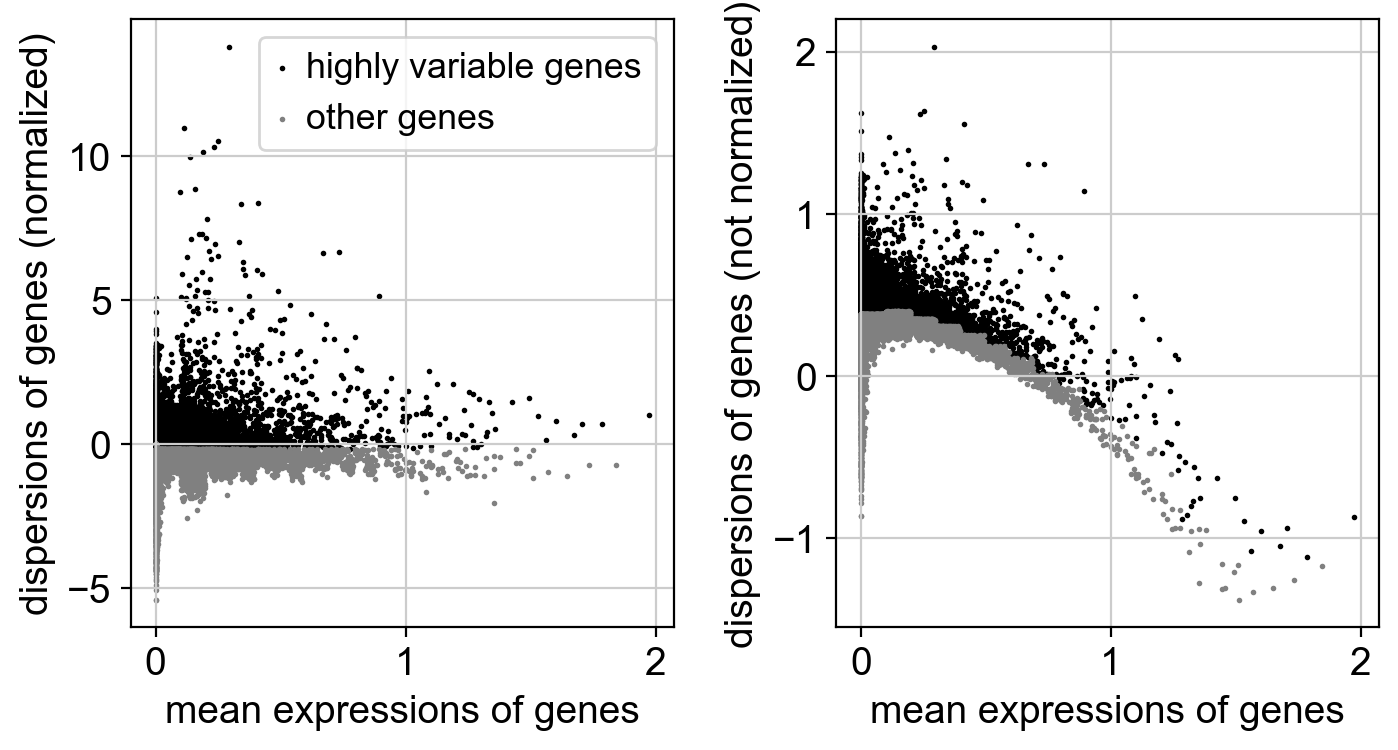

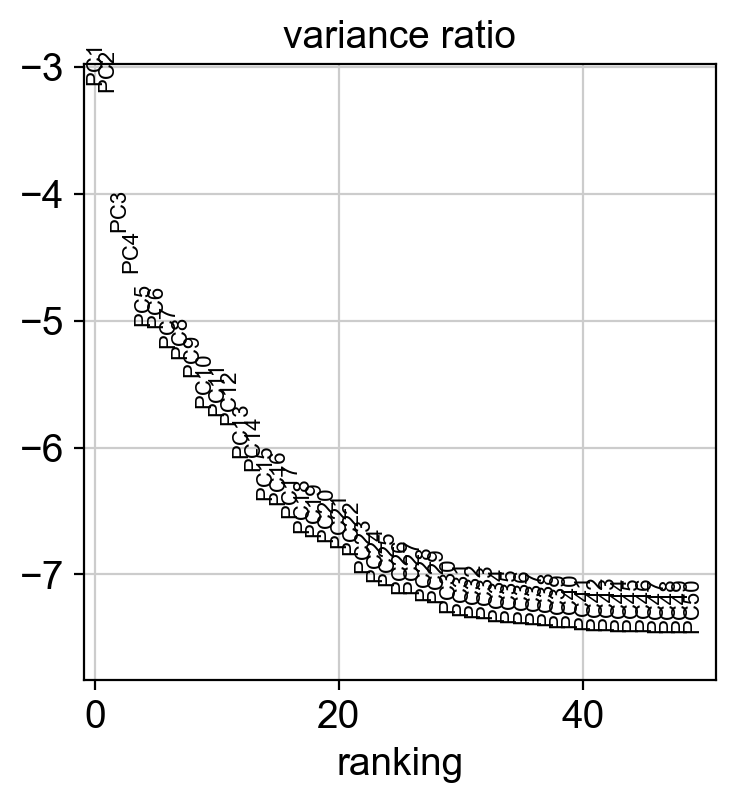

In [3]:
# Saving count data
rdata.layers["counts"] = rdata.X.copy()
# Normalizing to median total counts
sc.pp.normalize_total(rdata)
# Logarithmize the data
sc.pp.log1p(rdata)
sc.pp.highly_variable_genes(rdata, n_top_genes=10000, batch_key="sample")
sc.pl.highly_variable_genes(rdata)
sc.tl.pca(rdata)
sc.pl.pca_variance_ratio(rdata, n_pcs=50, log=True)
sc.pp.neighbors(rdata)
sc.tl.umap(rdata)


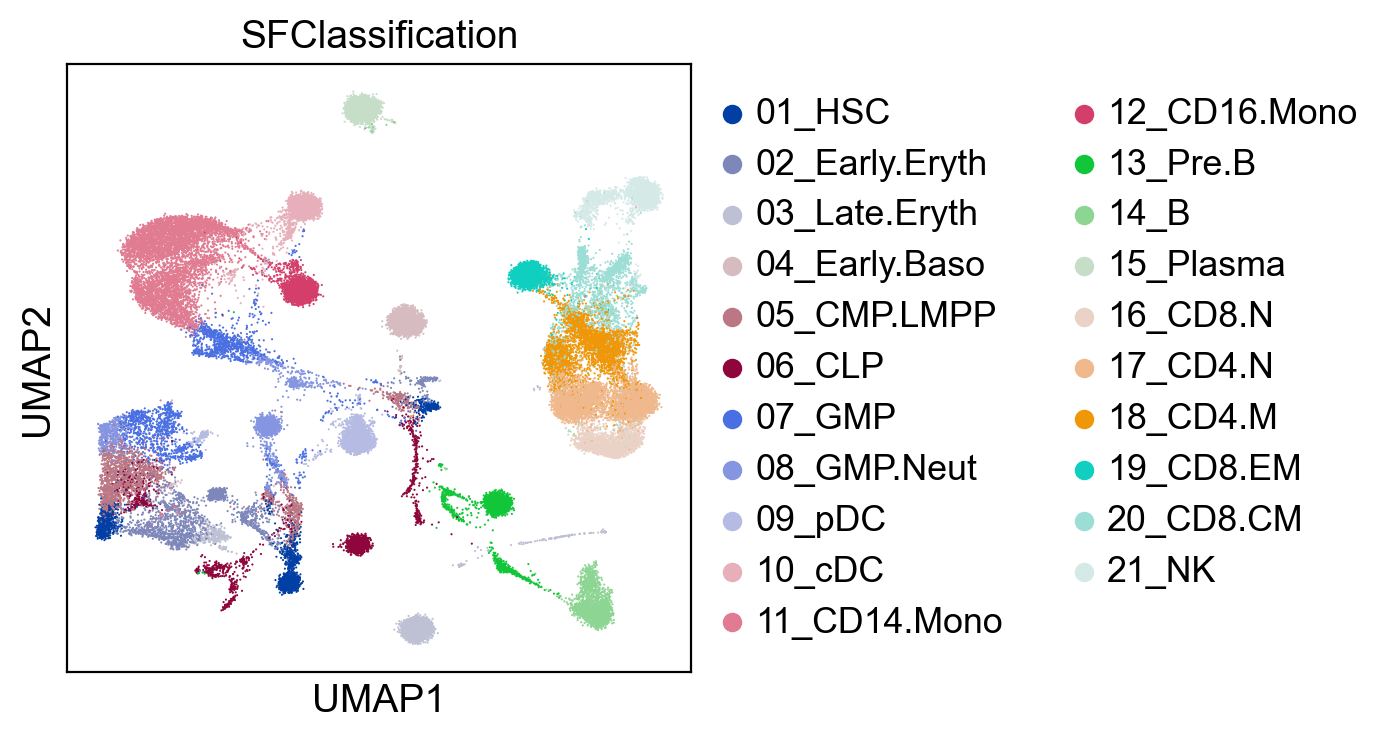

In [4]:
sc.pl.umap(rdata, color = "SFClassification")

In [5]:

umap = pd.read_csv(ROOT_DIR2+"/Greenleaf_HM_3file/3file/umap_reduction.tsv.gz", header=0, sep='\t', index_col=0)
rdata.obsm['X_umap2'] = rdata.obsm['X_umap']
rdata.obsm['X_umap']  = umap.to_numpy()

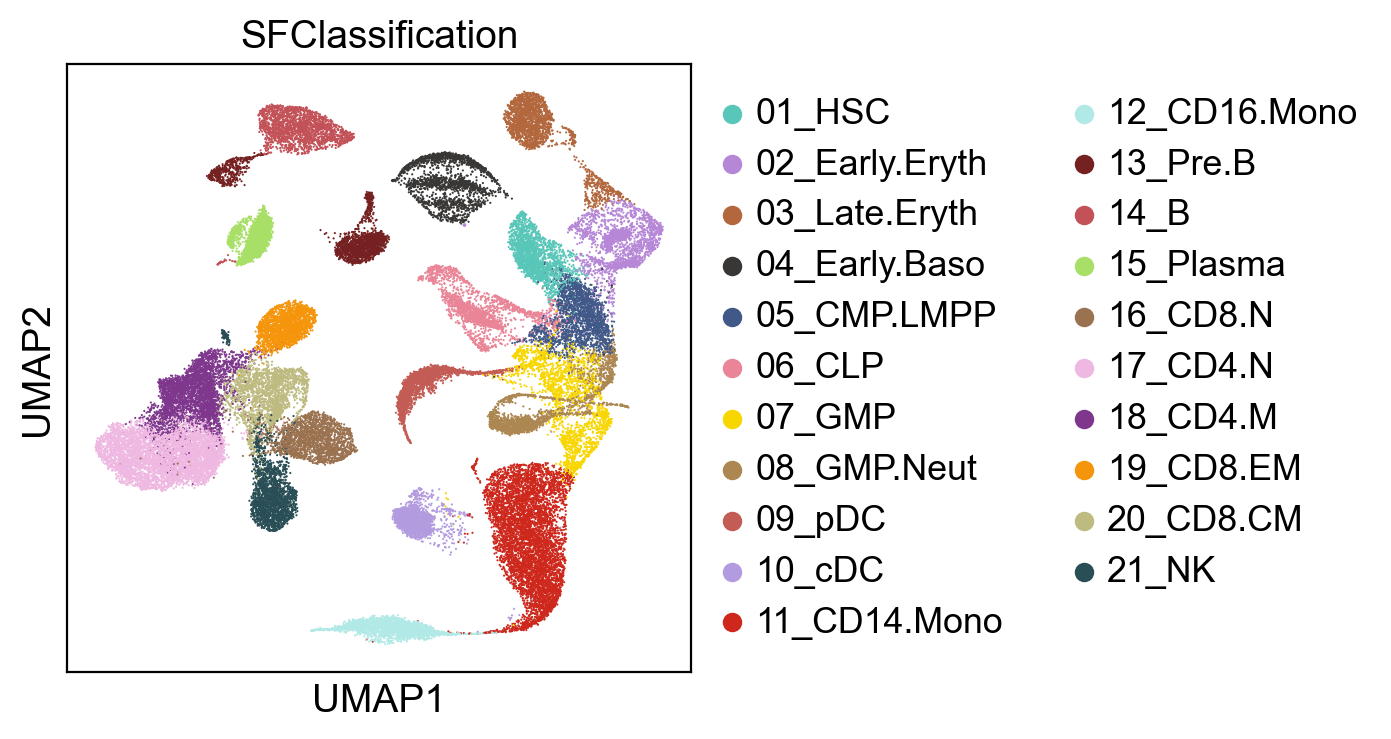

In [6]:
cols = []
with open(ROOT_DIR2+"/Greenleaf_HM_3file/3file/cols.tsv") as f:
    cols = [line.rstrip('\n') for line in f]
sc.pl.umap(rdata, color = "SFClassification", palette = cols)

## LOAD 3 FILE QUERY

In [7]:
samples = {
    "query": ROOT_DIR1+"/3file",
}
adatas = {}

for sample_id, filename in samples.items():
    sample_adata = sc.read_10x_mtx(filename)
    sample_adata.var_names_make_unique()
    adatas[sample_id] = sample_adata

adata = ad.concat(adatas, label="sample")
adata.obs_names_make_unique()
meta = pd.read_csv(ROOT_DIR1+"/3file/meta.csv", header=0, sep=',', index_col=0)
meta = meta.loc[adata.obs.index]
adata.obs = pd.concat([meta, adata.obs], axis=1)

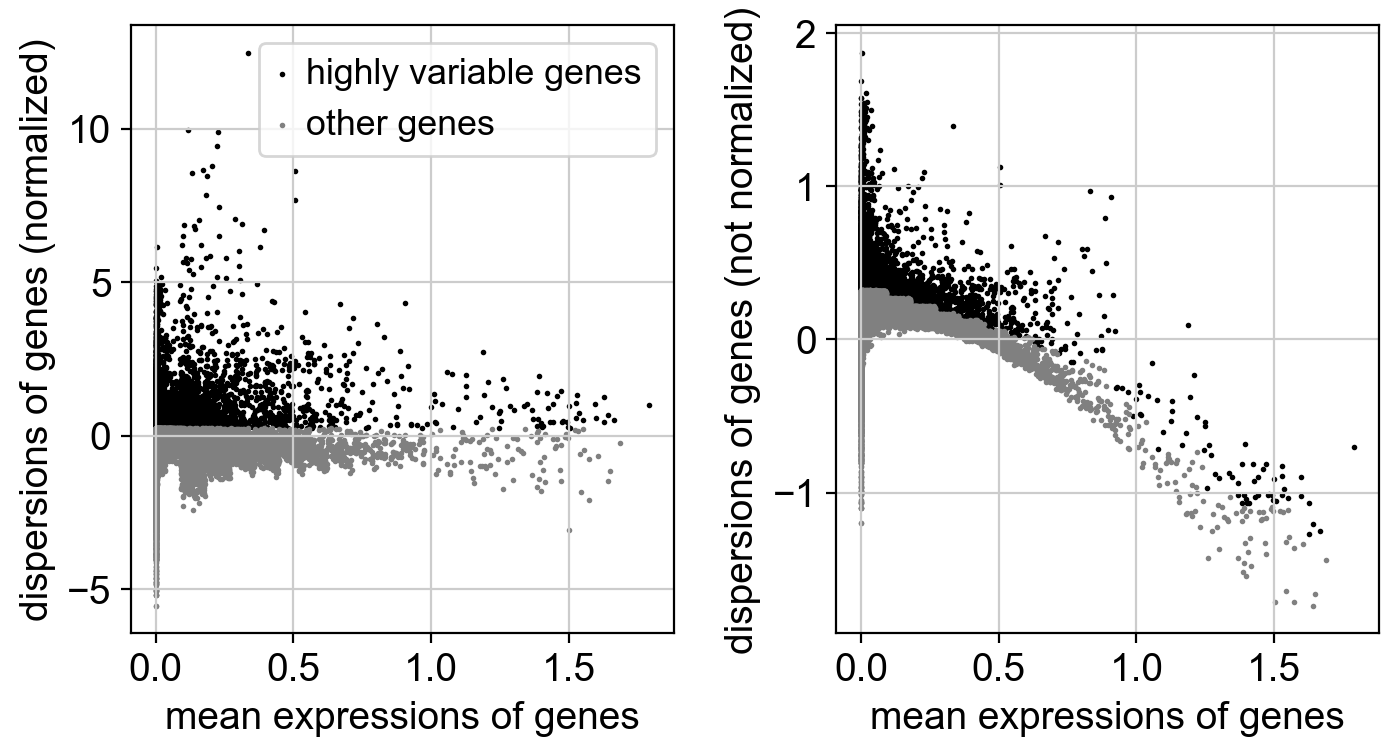

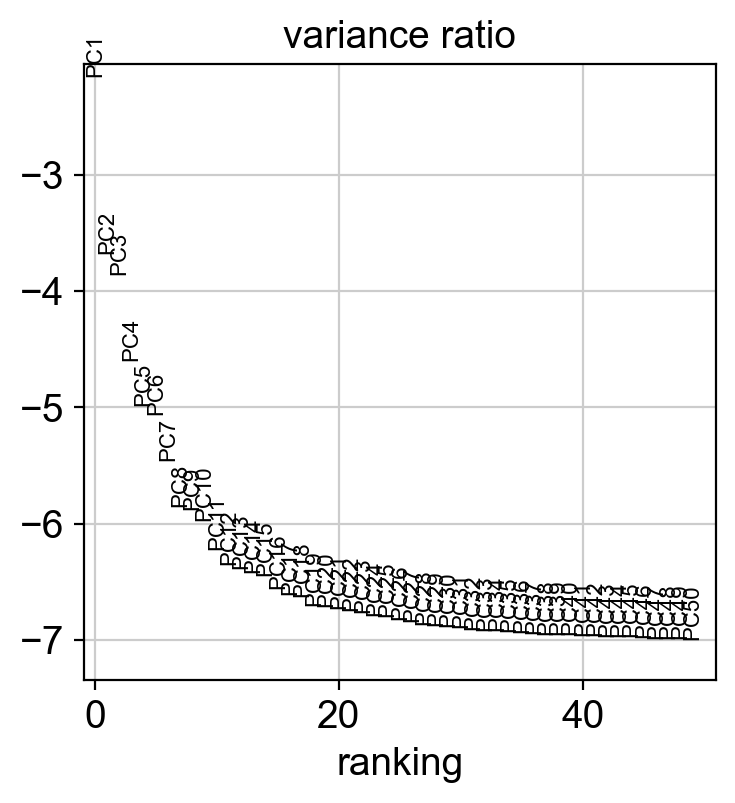

In [8]:
# Saving count data
adata.layers["counts"] = adata.X.copy()
# Normalizing to median total counts
sc.pp.normalize_total(adata)
# Logarithmize the data
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, n_top_genes=10000, batch_key="sample")
sc.pl.highly_variable_genes(adata)
sc.tl.pca(adata)
sc.pl.pca_variance_ratio(adata, n_pcs=50, log=True)
sc.pp.neighbors(adata)
sc.tl.umap(adata)

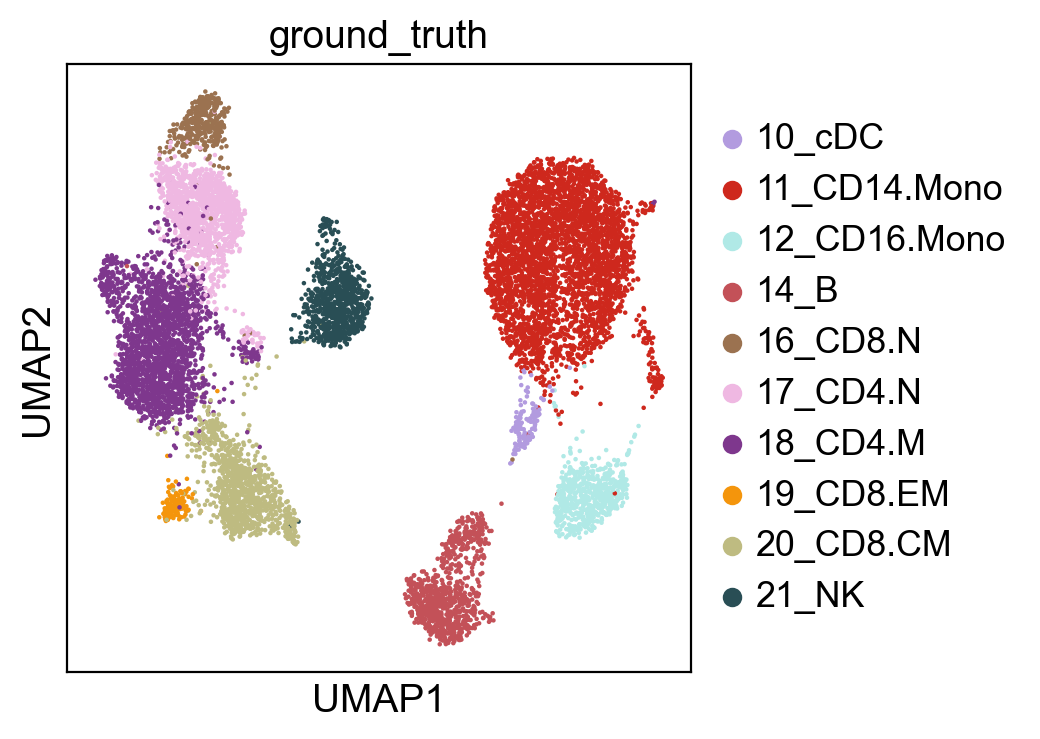

In [9]:

cols2 = dict(map(lambda i,j : (i,j) , sorted(rdata.obs["SFClassification"].unique()), cols))
sc.pl.umap(adata, color = "ground_truth", palette = cols2)

In [10]:
umap = pd.read_csv(ROOT_DIR1+"/3file/umap_reduction.tsv.gz", header=0, sep='\t', index_col=0)
adata.obsm['X_umap2'] = adata.obsm['X_umap']
adata.obsm['X_umap']  = umap.to_numpy()

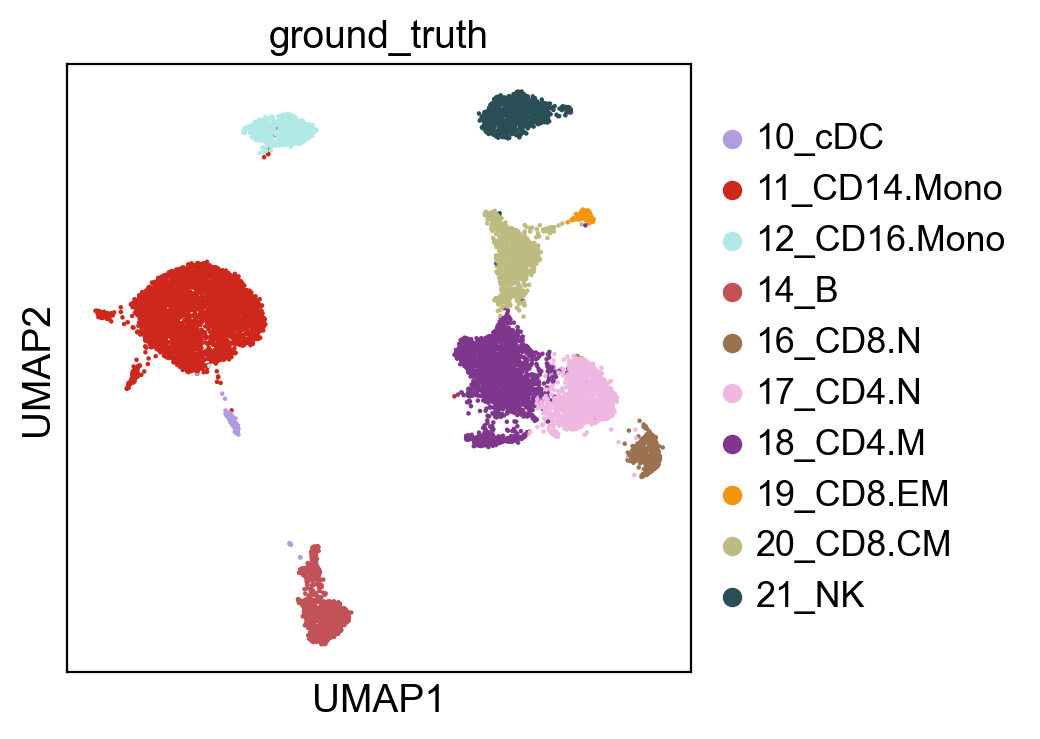

In [11]:
sc.pl.umap(adata, color = "ground_truth", palette = cols2)

## load pyviewmaster

In [23]:
import numpy as np
import scanpy as sc
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from scipy.sparse import issparse, vstack
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfTransformer
import warnings

def viewmaster(
    query_cds,
    ref_cds,
    ref_celldata_col,
    query_celldata_col="viewmaster_pred",
    FUNC="mlr",
    norm_method="log",
    selected_genes=None,
    train_frac=0.8,
    tf_idf=False,
    scale=False,
    hidden_layers=(500, 100),
    learning_rate=1e-3,
    max_epochs=200,
    LSImethod=1,
    verbose=True,
    return_probs=False,
    debug=False,
    **kwargs
):
    """
    Predict cell types in the query dataset using the reference dataset.
    The query_cds is modified in place, adding predictions to query_cds.obs.
    """
    if not isinstance(query_cds, sc.AnnData) or not isinstance(ref_cds, sc.AnnData):
        raise TypeError("query_cds and ref_cds must be AnnData objects.")

    if debug:
        print("Dimension check:")
        print(f"\tQuery shape: {query_cds.shape}")
        print(f"\tReference shape: {ref_cds.shape}")
        print(f"\tSelected genes: {len(selected_genes) if selected_genes else 'None'}")

    # Setup training data
    training_data = setup_training(
        query_cds,
        ref_cds,
        ref_celldata_col=ref_celldata_col,
        norm_method=norm_method,
        selected_genes=selected_genes,
        train_frac=train_frac,
        tf_idf=tf_idf,
        scale=scale,
        verbose=verbose,
        debug=debug,
    )

    # Choose the machine learning model
    FUNC = FUNC.lower()
    if FUNC == "mlr":
        export_list = process_learning_obj_mlr(
            X_train=training_data["X_train"],
            y_train=training_data["y_train"],
            X_query=training_data["X_query"],
            max_epochs=max_epochs,
            verbose=verbose,
        )
    elif FUNC == "nn":
        export_list = process_learning_obj_ann(
            X_train=training_data["X_train"],
            y_train=training_data["y_train"],
            X_query=training_data["X_query"],
            hidden_size=hidden_layers,
            learning_rate=learning_rate,
            max_epochs=max_epochs,
            verbose=verbose,
        )
    elif FUNC == "nb":
        export_list = process_learning_obj_nb(
            X_train=training_data["X_train"],
            y_train=training_data["y_train"],
            X_query=training_data["X_query"],
            verbose=verbose,
        )
    else:
        raise ValueError("FUNC must be one of 'mlr', 'nn', or 'nb'.")

    # Process predictions
    if FUNC == "nb":
        predictions = export_list["predictions"]
        query_cds.obs[query_celldata_col] = training_data["labels"][predictions]
    else:
        probabilities = export_list["probs"]
        predictions = np.argmax(probabilities, axis=1)
        query_cds.obs[query_celldata_col] = training_data["labels"][predictions]

        if return_probs:
            for i, label in enumerate(training_data["labels"]):
                query_cds.obs[f"prob_{label}"] = probabilities[:, i]

    if verbose:
        print(f"Predictions added to query_cds.obs['{query_celldata_col}']")

def setup_training(
    query_cds,
    ref_cds,
    ref_celldata_col,
    norm_method="log",
    selected_genes=None,
    train_frac=0.8,
    tf_idf=False,
    scale=False,
    LSImethod=1,
    verbose=True,
    debug=False,
):
    """
    Prepare training and query datasets.
    """
    if verbose:
        print("Preparing data...")

    # Find common features
    ref_cds, query_cds = common_features(ref_cds, query_cds)

    # Subset to selected genes if provided
    if selected_genes is not None:
        if verbose:
            print("Subsetting to selected genes.")
        selected_common = ref_cds.var_names.intersection(selected_genes)
        ref_cds = ref_cds[:, selected_common]
        query_cds = query_cds[:, selected_common]

    # Normalize data
    if verbose:
        print("Normalizing data...")
    ref_cds_norm = ref_cds.copy()
    query_cds_norm = query_cds.copy()
    normalize_data(ref_cds_norm, norm_method=norm_method)
    normalize_data(query_cds_norm, norm_method=norm_method)

    # Apply TF-IDF or scaling if specified
    if tf_idf:
        if verbose:
            print("Applying TF-IDF transformation.")
        apply_tfidf(ref_cds_norm)
        apply_tfidf(query_cds_norm)
    elif scale:
        if verbose:
            print("Scaling data.")
        sc.pp.scale(ref_cds_norm)
        sc.pp.scale(query_cds_norm)

    # Prepare labels
    labels = ref_cds_norm.obs[ref_celldata_col].values
    label_encoder = LabelEncoder()
    y_labels = label_encoder.fit_transform(labels)
    label_classes = label_encoder.classes_

    # Get data matrices
    X = ref_cds_norm.X
    X_query = query_cds_norm.X

    # Split train indices
    if train_frac < 1.0:
        train_idx, _ = train_test_split(
            np.arange(X.shape[0]), train_size=train_frac, stratify=y_labels
        )
        X_train = X[train_idx]
        y_train = y_labels[train_idx]
    else:
        X_train = X
        y_train = y_labels

    return {
        "X_train": X_train,
        "y_train": y_train,
        "X_query": X_query,
        "labels": label_classes,
    }

def common_features(ref_cds, query_cds):
    """
    Find and retain common genes between ref_cds and query_cds.
    """
    common_genes = ref_cds.var_names.intersection(query_cds.var_names)
    if len(common_genes) == 0:
        raise ValueError("No common genes found between reference and query datasets.")
    ref_cds = ref_cds[:, common_genes]
    query_cds = query_cds[:, common_genes]
    return ref_cds, query_cds

def normalize_data(adata, norm_method="log"):
    """
    Normalize counts in an AnnData object in-place.
    """
    if norm_method == "log":
        sc.pp.normalize_total(adata, target_sum=1e4)
        sc.pp.log1p(adata)
    elif norm_method == "binary":
        adata.X = (adata.X != 0).astype(float)
    elif norm_method == "size_only":
        sc.pp.normalize_total(adata, target_sum=1e4)
    elif norm_method == "none":
        pass  # Do nothing
    else:
        raise ValueError(f"Unknown norm_method: {norm_method}")

def apply_tfidf(adata):
    """
    Apply TF-IDF transformation to an AnnData object in-place.
    """
    X = adata.X
    transformer = TfidfTransformer(
        norm=None, use_idf=True, smooth_idf=True, sublinear_tf=False
    )
    if issparse(X):
        X = transformer.fit_transform(X.T).T  # Transpose for TF-IDF, then transpose back
    else:
        X = transformer.fit_transform(X.T).T
    adata.X = X

def process_learning_obj_mlr(
    X_train, y_train, X_query, max_epochs=200, verbose=True
):
    """
    Train and predict using multinomial logistic regression.
    """
    clf = LogisticRegression(
        multi_class="multinomial", solver="lbfgs", max_iter=max_epochs
    )
    clf.fit(X_train, y_train)
    predictions = clf.predict(X_query)
    probs = clf.predict_proba(X_query)
    return {"predictions": predictions, "probs": probs}

def process_learning_obj_ann(
    X_train, y_train, X_query, hidden_size=(500, 100), learning_rate=1e-3, max_epochs=200, verbose=True
):
    """
    Train and predict using a neural network.
    """
    clf = MLPClassifier(
        hidden_layer_sizes=hidden_size,
        learning_rate_init=learning_rate,
        max_iter=max_epochs,
        verbose=verbose,
    )
    clf.fit(X_train, y_train)
    predictions = clf.predict(X_query)
    probs = clf.predict_proba(X_query)
    return {"predictions": predictions, "probs": probs}

def process_learning_obj_nb(X_train, y_train, X_query, verbose=True):
    """
    Train and predict using Multinomial Naive Bayes.
    """
    clf = MultinomialNB()
    clf.fit(X_train, y_train)
    predictions = clf.predict(X_query)
    return {"predictions": predictions}


In [3]:
import pyviewmaster
#from pyviewmaster import viewmaster

ModuleNotFoundError: No module named 'pyviewmaster'

## find variable genes

In [24]:
def intersection(lst1, lst2):
    lst3 = [value for value in lst1 if value in lst2]
    return lst3
sc.pp.highly_variable_genes(adata,  n_top_genes=10000)
sc.pp.highly_variable_genes(adata,  n_top_genes=10000)
vg = intersection(adata.var.index[adata.var['highly_variable'].to_numpy()].tolist(), rdata.var.index[rdata.var['highly_variable'].to_numpy()].tolist())

In [25]:
viewmaster(adata, rdata, "SFClassification", query_celldata_col= "vmP_mlr", FUNC= "mlr", selected_genes=vg)
viewmaster(adata, rdata, "SFClassification", query_celldata_col= "vmP_nb", FUNC= "nb", selected_genes=vg)
viewmaster(adata, rdata, "SFClassification", query_celldata_col= "vmP_nn", FUNC= "nn", selected_genes=vg)

Preparing data...
Subsetting to selected genes.
Normalizing data...
Predictions added to query_cds.obs['vmP_mlr']
Preparing data...
Subsetting to selected genes.
Normalizing data...
Predictions added to query_cds.obs['vmP_nb']
Preparing data...
Subsetting to selected genes.
Normalizing data...
Iteration 1, loss = 0.27714515
Iteration 2, loss = 0.04778688
Iteration 3, loss = 0.01362445
Iteration 4, loss = 0.00445724
Iteration 5, loss = 0.00366412
Iteration 6, loss = 0.00153425
Iteration 7, loss = 0.00162885
Iteration 8, loss = 0.00123992
Iteration 9, loss = 0.00053923
Iteration 10, loss = 0.00049127
Iteration 11, loss = 0.00046840
Iteration 12, loss = 0.00045255
Iteration 13, loss = 0.00044003
Iteration 14, loss = 0.00042964
Iteration 15, loss = 0.00042080
Iteration 16, loss = 0.00041299
Iteration 17, loss = 0.00040592
Iteration 18, loss = 0.00039928
Iteration 19, loss = 0.00039307
Iteration 20, loss = 0.00038709
Training loss did not improve more than tol=0.000100 for 10 consecutive ep

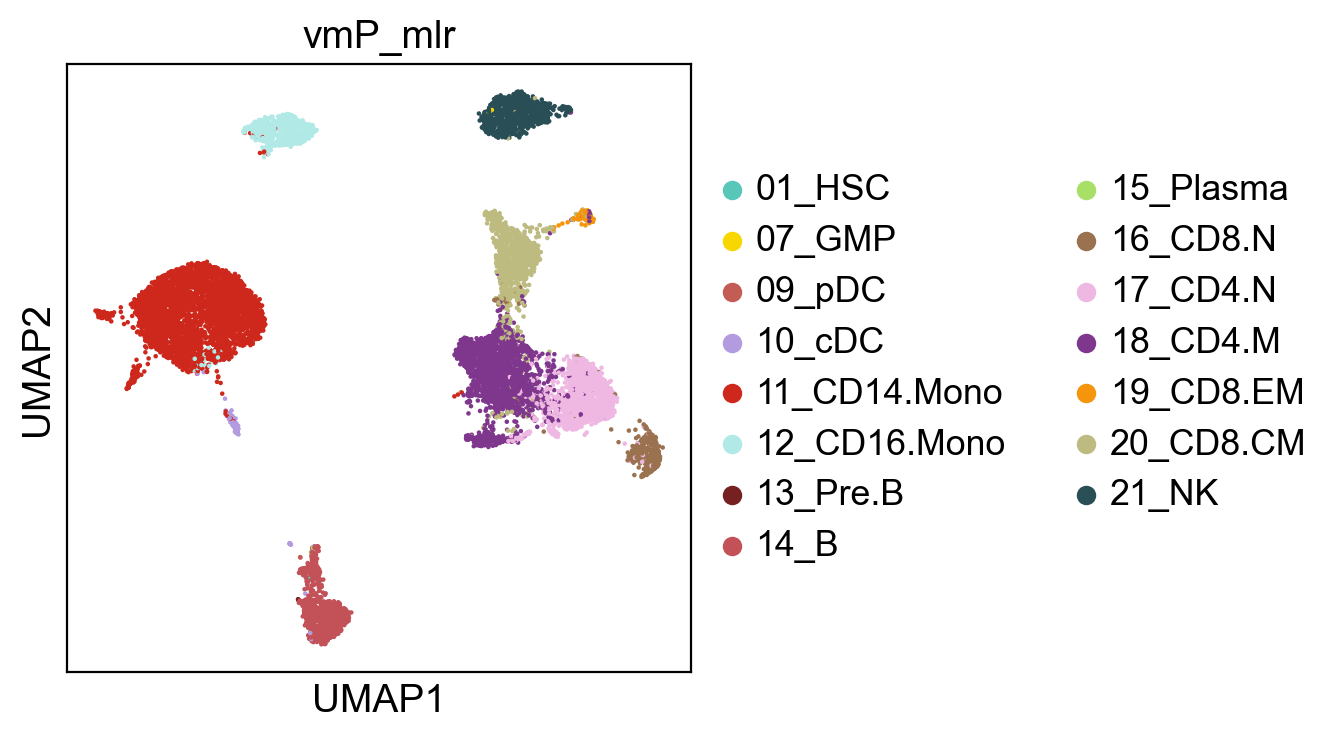

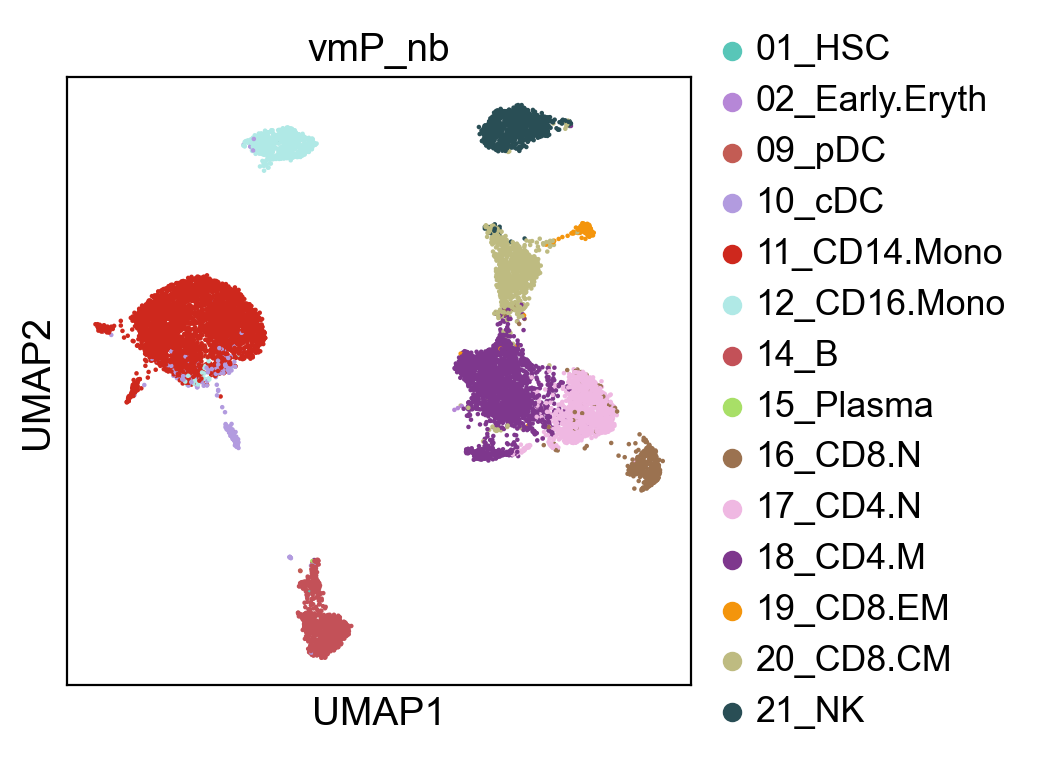

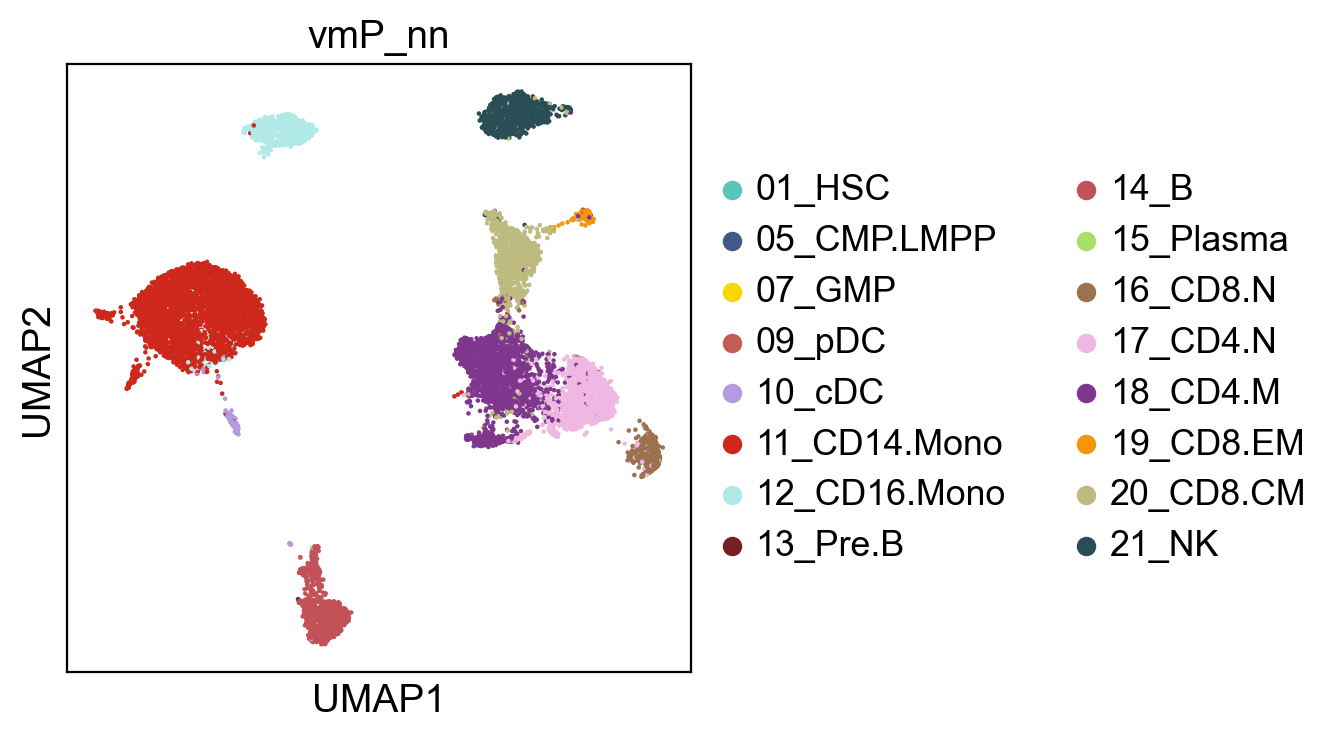

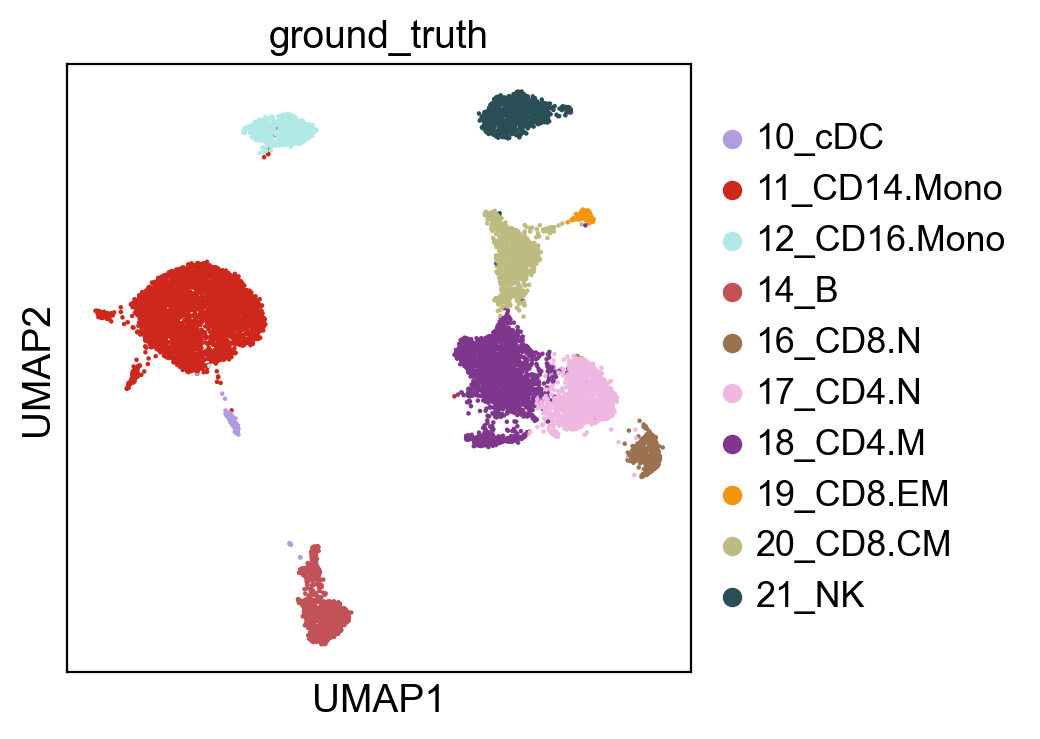

In [26]:
sc.pl.umap(adata, color = "vmP_mlr", palette = cols2)
sc.pl.umap(adata, color = "vmP_nb", palette = cols2)
sc.pl.umap(adata, color = "vmP_nn", palette = cols2)
sc.pl.umap(adata, color = "ground_truth", palette = cols2)